In [1]:
import os
import gc
import parse
import logging
import numpy as np
import pandas as pd
from utils import get_N_tokens, read_and_split_file, raw_dir, interim_dir, final_dir, load_SET_dataset, LABELS, load_rss_dataset

logging.basicConfig(format="%(asctime)s - %(message)s", level=logging.INFO)

# Reading the training dataset (WebCrawl):

In [2]:
texts, labels = list(), list()

files = ["bswac_tail_pp", "cnrwac_tail_pp_corrected_2", "hrwac_tail_pp", "srwac_tail_pp"]

langs = ["bs", "me", "hr", "sr"]

for file, lang in zip(files, langs):
    full_path = os.path.join(interim_dir, file)
    current_texts = read_and_split_file(full_path)
    len_cur_texts = len(current_texts)
    texts.extend(current_texts)
    labels.extend([lang] * len_cur_texts)

train = pd.DataFrame(data={"text": texts, "labels": labels})

# Loading the eval df:

In [3]:
eval_df = load_rss_dataset()

# Defining the eval functions and clf:

In [13]:
from sklearn.svm import LinearSVC
clf_lin_svc = LinearSVC(dual=False)

def get_stats(N: int, train=train, eval_df=eval_df, clf=clf_lin_svc, labels=LABELS):
    import gc
    from sklearn.feature_extraction.text import CountVectorizer
    from sklearn.metrics import (
        f1_score,
        ConfusionMatrixDisplay,
        confusion_matrix,
        accuracy_score,
    )

    gc.collect()
    vocabulary = get_N_tokens(N)

    def get_coverage(s:str) -> int:
        """Calculates how many vocabulary tokens are in the string.

        Args:
            s (str): input string

        Returns:
            int: number of DISTINCT vocabulary tokens in input string.
        """        
        word_set = set(s.split(" "))
        return len(word_set.intersection(vocabulary))
    vectorizer = CountVectorizer(vocabulary=vocabulary, lowercase=True, binary=True)
    
    eval_df["coverage"] = eval_df.text.apply(get_coverage)
    average_coverage = eval_df.coverage.mean()


    train_vectors = vectorizer.fit_transform(train.text)
    train_labels = train.labels
    test_vectors = vectorizer.fit_transform(eval_df.text)
    y_true = eval_df.labels


    clf.fit(train_vectors.toarray(), train_labels)
    y_pred = clf.predict(test_vectors.toarray())
    LABELS = labels
    macro = f1_score(y_true, y_pred, labels=LABELS, average="macro")
    micro = f1_score(y_true, y_pred, labels=LABELS, average="micro")
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=LABELS)
    bool_coverage = eval_df.coverage.value_counts()[0]
    returndict = {"N": N, "microF1": micro, "macroF1": macro, "accuracy": acc, "cm": cm,
    "coverage": average_coverage, "clf": clf.__str__(), "bool_coverage": bool_coverage,
    "bool_coverage_ratio": bool_coverage/len(y_true)}
    for lang in LABELS:
        idx = eval_df.labels == lang
        M = idx.sum()
        returndict[f"bool_coverage_ratio_{lang}"] = eval_df.loc[idx, "coverage"].value_counts().get(0, 0) / M
    return returndict

# Defining the clf and running the eval loop:

In [14]:
Ns = np.logspace(1, 4, 20, dtype=np.int)
results = list()
for N in Ns:
    try:
        logging.info(f"{N=}")
        rezdict = get_stats(N, train=train, eval_df=eval_df, clf=clf_lin_svc, labels=LABELS)
        rezdict["eval_df"] = "RSS"
        results.append(rezdict)
    except MemoryError:
        break


2022-01-21 11:10:03,686 - N=10
2022-01-21 11:10:58,176 - N=14
2022-01-21 11:11:53,868 - N=20
2022-01-21 11:12:50,142 - N=29
2022-01-21 11:13:49,106 - N=42
2022-01-21 11:14:48,302 - N=61
2022-01-21 11:15:50,252 - N=88
2022-01-21 11:16:51,832 - N=127
2022-01-21 11:17:57,750 - N=183
2022-01-21 11:19:04,109 - N=263
2022-01-21 11:20:16,849 - N=379
2022-01-21 11:21:33,896 - N=545
2022-01-21 11:22:56,799 - N=784
2022-01-21 11:24:22,656 - N=1128
2022-01-21 11:25:56,873 - N=1623
2022-01-21 11:27:41,697 - N=2335
2022-01-21 11:29:43,809 - N=3359
2022-01-21 11:32:10,683 - N=4832
2022-01-21 11:35:10,422 - N=6951
2022-01-21 11:40:41,594 - N=10000


In [12]:
eval_df.coverage.value_counts().get(0)

72

In [8]:
rezdf = pd.DataFrame(data=results)
rezdf.index = rezdf.N
rezdf = rezdf.drop(columns=["N"])
rezdf = rezdf.sort_index()
rezdf.to_csv("22_results_LinSVC_on_RSS_crawl.csv")
rezdf

,microF1,macroF1,accuracy,cm,coverage,clf,bool_coverage,bool_coverage_ratio,bool_coverage_ratio_hr,bool_coverage_ratio_bs,bool_coverage_ratio_sr,bool_coverage_ratio_me,eval_df
N,,,,,,,,,,,,,
10,0.246229,0.262686,0.246229,"[[2047, 403, 1, 5421], [131, 375, 27, 2187], [...",0.616476,LinearSVC(dual=False),11034,0.623425,0.664507,0.663603,0.571150,0.431507,RSS
14,0.365614,0.350474,0.365614,"[[2825, 542, 3, 4502], [185, 400, 44, 2091], [...",1.039437,LinearSVC(dual=False),8375,0.473191,0.518293,0.558456,0.392413,0.363014,RSS
20,0.447878,0.435678,0.447878,"[[3113, 1106, 4, 3649], [245, 1086, 50, 1339],...",1.595401,LinearSVC(dual=False),5818,0.328719,0.385163,0.246324,0.299745,0.267123,RSS
29,0.509464,0.468265,0.509464,"[[4023, 1446, 4, 2399], [268, 1161, 52, 1239],...",2.288886,LinearSVC(dual=False),3827,0.216227,0.198806,0.179044,0.252362,0.210046,RSS
42,0.572857,0.502830,0.572857,"[[4836, 1490, 3, 1543], [304, 1184, 56, 1176],...",3.384202,LinearSVC(dual=False),2253,0.127295,0.107978,0.125735,0.148598,0.159817,RSS
61,0.576078,0.503563,0.576078,"[[4831, 1759, 3, 1279], [311, 1257, 56, 1096],...",4.181084,LinearSVC(dual=False),1735,0.098028,0.080793,0.099632,0.115160,0.136986,RSS
88,0.595853,0.517871,0.595853,"[[4951, 1847, 3, 1071], [286, 1365, 52, 1017],...",5.141872,LinearSVC(dual=False),1374,0.077632,0.055894,0.077206,0.100765,0.118721,RSS
127,0.611221,0.527938,0.611221,"[[5070, 1876, 3, 923], [296, 1407, 46, 971], [...",6.324030,LinearSVC(dual=False),1077,0.060851,0.040777,0.054779,0.085170,0.089041,RSS
183,0.655404,0.553498,0.655404,"[[5097, 2136, 7, 632], [402, 1457, 46, 815], [...",7.892875,LinearSVC(dual=False),504,0.028476,0.025788,0.038603,0.024741,0.070776,RSS


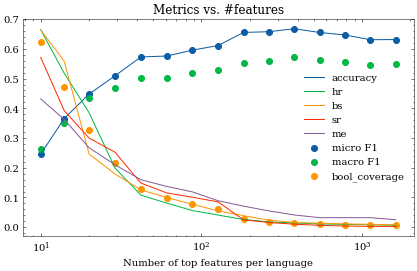

In [9]:
import matplotlib.pyplot as plt
plt.style.use(["science", "no-latex"])

plt.figure(figsize=(7, 4))
plt.scatter(rezdf.index, rezdf["microF1"],label="micro F1")

plt.scatter(rezdf.index, rezdf["macroF1"],label="macro F1")

plt.plot(rezdf.index, rezdf["accuracy"],label="accuracy")
plt.scatter(rezdf.index, rezdf["bool_coverage_ratio"],label="bool_coverage")
plt.xlabel("Number of top features per language")

for lang in LABELS:
    plt.plot(rezdf.index, rezdf[f"bool_coverage_ratio_{lang}"], label=f"{lang}")
plt.legend()
plt.title("Metrics vs. #features")
plt.semilogx()
plt.savefig("images/22_LinSVC_on_RSS.png")
plt.show()